In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
columns = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
# Load the dataset
types = {'InvoiceNo': str, 'StockCode': str, 'Description': str, 'Quantity': int, 'InvoiceDate': str, 'UnitPrice': float, 'CustomerID': float, 'Country': str}
data = pd.read_csv('../Data/Online_Retail.csv', dtype=types, usecols=columns)

## Data preprocessing

In [4]:
prep_data = data[~data['InvoiceNo'].str.startswith('C')] # remove cancelled orders

In [ ]:
prep_data.dropna(inplace=True) # remove rows with missing values

prep_data.drop_duplicates(inplace=True) # remove duplicate rows

In [6]:
prep_data['TotalPrice'] = prep_data['Quantity'] * prep_data['UnitPrice'] # calculate total price
prep_data['InvoiceDate'] = pd.to_datetime(prep_data['InvoiceDate']) # convert InvoiceDate to datetime




In [7]:
#remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
prep_data = remove_outliers(prep_data, 'TotalPrice') # remove outliers in TotalPrice
prep_data = remove_outliers(prep_data, 'Quantity') # remove outliers in Quantity
prep_data = remove_outliers(prep_data, 'UnitPrice') # remove outliers in UnitPrice


# Clustering

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [23]:
preCluster = prep_data[['Quantity','UnitPrice','Country']].copy()
 

In [24]:
# encode categorical variables
preCluster = pd.get_dummies(preCluster, columns=['Country'])

In [ ]:
scaler = StandardScaler()
preCluster[['Quantity','UnitPrice']] = scaler.fit_transform(preCluster[['Quantity','UnitPrice']])

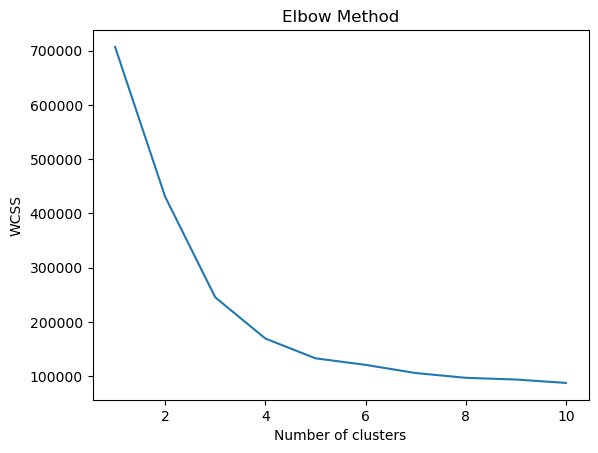

In [26]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(preCluster)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [27]:
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(preCluster)

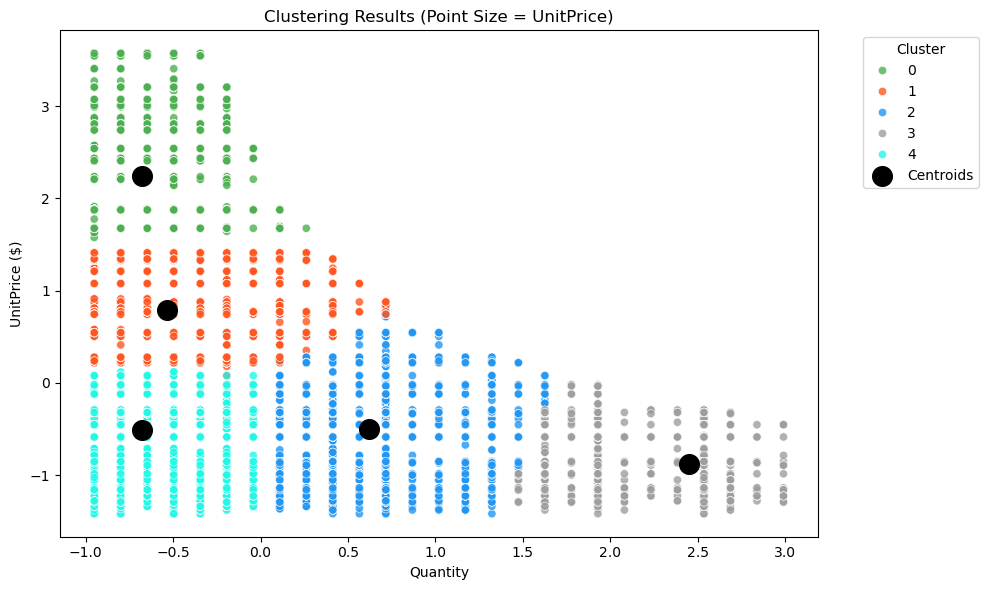

In [28]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=preCluster, x='Quantity', y='UnitPrice', hue=labels 
                , palette=['#4CAF50', '#FF5722', '#2196F3', '#9E9E9E',"#22F8E6"], alpha=0.8)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', label='Centroids')
plt.title('Clustering Results (Point Size = UnitPrice)')
plt.xlabel('Quantity')
plt.ylabel('UnitPrice ($)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [29]:
prep_data['cluster'] = labels

In [30]:
segment_summary = prep_data.groupby('cluster').agg({
    'Quantity': 'mean',
    'UnitPrice': 'mean',
    'TotalPrice': 'sum',
    'Country': lambda x: x.mode()[0],
    'Description': lambda x: x.mode()[0],
    'InvoiceNo': 'count'
}).rename(columns={'InvoiceNo': 'Count'})

In [31]:
segment_summary

,Quantity,UnitPrice,TotalPrice,Country,Description,Count
cluster,,,,,,
0,2.818371,5.497387,476001.050,United Kingdom,PARTY BUNTING,31212
1,3.739008,3.326127,851596.080,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER,69320
2,11.376627,1.378868,1366503.440,United Kingdom,ASSORTED COLOUR BIRD ORNAMENT,87872
3,23.428618,0.814088,567075.720,United Kingdom,PACK OF 72 RETROSPOT CAKE CASES,30428
4,2.809109,1.355757,402046.544,United Kingdom,REX CASH+CARRY JUMBO SHOPPER,104924


In [52]:
# top 5 countries in each cluster
top_countries = prep_data.groupby('cluster')['Country'].value_counts().groupby(level=0).head(5).reset_index(name='Count')
top_countries = top_countries.pivot(index='cluster', columns='Country', values='Count').fillna(0)
top_countries = top_countries.astype(int)  # Convert counts to integers
top_countries = top_countries.reset_index()
top_countries.columns.name = None  # Remove the name of the columns index
top_countries = top_countries.set_index('cluster')


In [53]:
top_countries

,Belgium,EIRE,France,Germany,Spain,Switzerland,United Kingdom
cluster,,,,,,,
0,0,660,439,569,224,0,28312
1,0,1229,1382,1430,468,0,62559
2,824,2204,3251,3600,0,0,73598
3,0,758,974,1096,0,293,25623
4,0,311,595,454,386,0,102284
